# Projeto 1 - Ciência dos Dados

Nome: Felipe Schiavinato

Nome: Jerônimo Afrange

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
/Users/jeronimo/Desktop/Insper/2/CDADOS/p1-cdados


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [3]:
filename = 'bitcoin.xlsx'

In [4]:
dados_treinamento = pd.read_excel(filename)
dados_treinamento

,tweets,relevancia
0,do you think it is ethical of exchanges to ear...,3.0
1,@junkosu22993224: citi bank is the first major...,3.0
2,@wsbmod: it's time to decentralize wallstreetb...,2.0
3,@iamlluciana charlie the bitcoin fund manager ...,1.0
4,#btc #bitcoin #forex\nus stocks set for swoon ...,0.0
...,...,...
746,"#bitcoin is falling below 56,000 $ usd",2.0
747,@coinmarketcap your #bitcoin price is showing ...,3.0
748,@wealth_theory: i cannot understand how you ca...,3.0
749,"@themooncarl: #bitcoin at $100,000 doesn’t see...",3.0


In [5]:
dados_teste = pd.read_excel(filename, sheet_name = 'Teste')
dados_teste.head

<bound method NDFrame.head of                                                 tweets  relevancia
0    @phorecrypto: a snapshot of #phore blockchain ...         2.0
1    @riena_smile: bottlepay launches twitter bitco...         3.0
2    @btc_archive: #bitcoin on target for 75k  in t...         3.0
3    @grady_booch at this stage it seems vanishingl...         3.0
4    @ragnarly i have 3 kids. simply cant ask aroun...         2.0
..                                                 ...         ...
496  ethereum could replace bitcoin to become top c...         3.0
497  will #paint #abstract 4 #crypto #bitcoin  #eth...         0.0
498  i don’t agree with gary on bitcoin but i total...         2.0
499  @meanhash: you either get it, or you don't. #b...         2.0
500                                                NaN         NaN

[501 rows x 2 columns]>

___
## Classificador automático de sentimento


Faça aqui uma descrição do seu produto e o que considerou como relevante ou não relevante na classificação dos tweets.

O nosso produto é o Bitcoin, e temos como objetivo analisar a opinião do público a respeito dessa criptomoeda específica. Classificamos a relevância dos Tweets com uma nota de 0 a 4, sendo 0 completamente irrelevante e 4 completamente relevante.

Consideramos como completamente irrelevantes Tweets que mencionam o nome Bitcoin mas não estão relacionados à criptomoeda, assim como Tweets de zombaria.

Consideramos como completamente relevantes Tweets que mencionam a criptomoeda, sejam, de fato, a respeito do nosso produto e autênticos.

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [6]:
# elementos bloqueados
blacklist = "[!-—.:?;,#…']•()1234567890%$/\’+*" + '"“”'

# palavras inúteis
with open('useless_words.txt') as file:
    palavras_inuteis = file.read().split()

In [7]:

def treinar(dados_treinamento):
    '''
        Treina o algorítmo
        dados_treinamento: DataFrame com relevâncias e tweets
    '''
    
    # lista de palavras extraídas
    palavras_por_relevancia = [[],[],[],[],[]]

    tweets = dados_treinamento['tweets']
    relevancias = dados_treinamento['relevancia']
    
    # loop que passa tweet por tweet
    for indice in range(len(tweets)):

        # cria constantes 'tweet_original' e 'relevancia'
        try: relevancia = int(relevancias[indice])
        except: continue
        tweet_original = tweets[indice]

        tweet_limpo = cleanup(tweet_original)

        # adicionando as palavras à lista de palavras da respectiva relevância
        palavras_por_relevancia[relevancia] += tweet_limpo
    
    # define a lista que conterá as series das frequências normalizadas
    # das palavras para cada grau de relevancia
    tabelas_relativas_por_relevancia = list()
    palavras_ingles = list()

    for palavras in palavras_por_relevancia:
        tabelas_relativas_por_relevancia.append(pd.Series(palavras).value_counts(True))
        palavras_ingles += palavras

    tabela_ingles_relativa = pd.Series(palavras_ingles).value_counts(True)
        
    return tabelas_relativas_por_relevancia, tabela_ingles_relativa


In [8]:

def cleanup(tweet_original):
    
    # remove links e nomes de usuário
    tweet_lista = tweet_original.split()
    tweet_sem_nomes_links = list()
    
    for palavra in tweet_lista:
        
        # remove letras maiúsculas
        palavra = palavra.lower()
                
        not_link = 'http' not in palavra
        not_usuario = '@' not in palavra
        
        if not_link and not_usuario:
            tweet_sem_nomes_links.append(palavra)
        
    tweet = ' '.join(tweet_sem_nomes_links)
    
    '''
    *** a partir desse ponto, 'tweet' não tem mais nomes de usuário nem links
    '''
    
    # remove caracteres bloqueados
    for carac in blacklist:
        
        if carac in tweet:
            tweet = tweet.split(carac)
            tweet = ' '.join(tweet)
                
    '''
    *** a partir desse ponto, 'tweet' não tem mais caracteres bloqueados
    '''
        
    # remove palavras inúteis
    tweet = tweet.split()
    
    for inutil in palavras_inuteis:
        while inutil in tweet:
            tweet.remove(inutil)
    
    tweet = ' '.join(tweet)
            
    '''
    *** a partir desse ponto, 'tweet' não tem mais palavras inúteis
    '''
                
    # remove espaços em branco duplos
    tweet = tweet.split()
    while '' in tweet: tweet.remove('')
    tweet = ' '.join(tweet)
    
    '''
    *** a partir desse ponto, 'tweet' não tem espaços em branco repetidos
    '''
    
    return tweet.split()


In [9]:

tabelas_relevancias_inicial, tabela_ingles_inicial = treinar(dados_treinamento)


___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [10]:

def testar(dados_teste, tabelas_relevancias):
    
    tweets_testes = list(dados_teste['tweets'])
    relevancias = list(dados_teste['relevancia'])

    certo_errado = list()
    menor_maior = list()

    for indice in range(len(dados_teste)): 

        lista_frase_limpa = cleanup(str(tweets_testes[indice]))
        relevancia_real = relevancias[indice]

        # Probabilidades de uma palavra qualquer pertencer a um grupo de relevância específico

        lens_relevancias = list()

        for palavras in tabelas_relevancias:
            lens_relevancias.append(len(palavras))

        len_total = sum(lens_relevancias)

        probabilidades_individuais = list()

        for indice in range(5):
            probabilidade = lens_relevancias[indice] / len_total
            probabilidades_individuais.append(probabilidade)

        # Cálculo da probalidade da frase aparecer dado um grau de relevância específico

        probabilidades_frase_dada_relevancia = [1] * 5

        for indice in range(5):

            for palavra in lista_frase_limpa:

                try: probPalavraDadaRelevancia = tabelas_relevancias[indice][palavra]
                except KeyError: probPalavraDadaRelevancia = 0

                vezes_palavra_aparece_na_relevancia = probPalavraDadaRelevancia * lens_relevancias[indice]
                probPalavraDadaRelevanciaPosLaplace = (vezes_palavra_aparece_na_relevancia + 1) / (lens_relevancias[indice] + len_total)

                probabilidades_frase_dada_relevancia[indice] *= probPalavraDadaRelevanciaPosLaplace


        maior_probabilidade_encontrada = max(probabilidades_frase_dada_relevancia)
        relevancia_mais_provavel = probabilidades_frase_dada_relevancia.index(maior_probabilidade_encontrada)

        try:
            certo_errado.append(relevancia_mais_provavel == int(relevancia_real))
            if relevancia_mais_provavel > relevancia_real: menor_maior.append('+')
            else: menor_maior.append('-')
        except: continue

    resultados = list()

    for indice in range(len(certo_errado)):

        if certo_errado[indice]: # se resultado correto
            resultados.append('verdadeiro')

        else:

            if menor_maior[indice] == '+':
                resultados.append('falso positivo')

            else:
                resultados.append('falso negativo')


    resultados = pd.Series(resultados).value_counts(True)
    return resultados


In [11]:
resultados_teste = testar(dados_teste, tabelas_relevancias_inicial)
resultados_teste

verdadeiro        0.415323
falso positivo    0.296371
falso negativo    0.288306
dtype: float64

<b>Interpretação dos resultados:</b>

Mensagens com dupla negação e/ou sarcasmo não são consideradas pelo algorítmo, já que ele interpreta a relevância das mensagens pelas palavras individualmente. Palavras por si só não têm significados semânticos, tais como sarcasmo e dupla negação.
    
Não é benéfico treinar o algorítmo com dados produzidos por ele mesmo porque sua taxa de acerto dificilmente será de 100%, com isso, propagar-se-iam dados incorretos, diminuindo ainda mais a taxa de acerto.

Outros possíveis usos para o classificador de Naive Bayes seriam: implementação de um sistema de diagnóstico médico automatizado e sistema de decisão de carros autônomos.

Uma possível melhora no classificador seria agrupar palavras semelhantes em uma palavra só, por exemplo, fazer com que palavras do mesmo verbo sob diferentes conjugações sejam consideradas iguais. Outra melhoria possível seria considerar combinações de palavras frequentes, tais como "show de bola" ou "bom dia". Uma terceira, penalizar palavras que aparecem frequentemente em textos relevantes e irrelevantes; já que essas palavras não convém muita informação por serem muito comuns em ambos os lados.

https://en.wikipedia.org/wiki/Lemmatisation

https://sebastianraschka.com/Articles/2014_naive_bayes_1.html#n-grams

https://en.wikipedia.org/wiki/Tf%E2%80%93idf


___
### Concluindo

In [14]:

tweets_teste = pd.DataFrame()
tweets_teste['tweets'] = dados_teste['tweets']
tweets_teste['relevancia'] = dados_teste['relevancia']

tweets_treinamento = pd.DataFrame()
tweets_treinamento['tweets'] = dados_treinamento['tweets']
tweets_treinamento['relevancia'] = dados_treinamento['relevancia']

todos_dados = pd.concat([tweets_teste, tweets_treinamento], sort=True)


# loop de treinamento e teste :)

taxas_acerto = list()

for i in range(100):
    
    tweets_embaralhados = todos_dados.sample(frac=1)
    
    dados_treinamento = tweets_embaralhados[:750]
    dados_teste = tweets_embaralhados[751:]
    
    # treinando o algorítimo com os novos dados de treinamento
    tabelas_relevancias, tabela_ingles = treinar(dados_treinamento)
    
    resultados_teste = testar(dados_teste, tabelas_relevancias)
    
    taxa_acerto = float(resultados_teste[0])
    taxas_acerto.append(taxa_acerto)
    
    print(i + 1, end=': ')
    print(taxa_acerto)

0: 0.39595959595959596
1: 0.4032258064516129
2: 0.42828282828282827
3: 0.4044265593561368
4: 0.4262626262626263
5: 0.4245472837022133
6: 0.4666666666666667
7: 0.4032258064516129
8: 0.43775100401606426
9: 0.4334677419354839
10: 0.4314516129032258
11: 0.4173387096774194
12: 0.46060606060606063
13: 0.41330645161290325
14: 0.41967871485943775
15: 0.40963855421686746
16: 0.3951612903225806
17: 0.4718875502008032
18: 0.386317907444668
19: 0.4383838383838384
20: 0.4202020202020202
21: 0.41851106639839036
22: 0.40562248995983935
23: 0.4433198380566802
24: 0.39878542510121456
25: 0.4305835010060362
26: 0.4305835010060362
27: 0.4303030303030303
28: 0.3878787878787879
29: 0.40606060606060607
30: 0.4303030303030303
31: 0.41935483870967744
32: 0.38832997987927564
33: 0.41414141414141414
34: 0.45180722891566266
35: 0.41330645161290325
36: 0.3951612903225806
37: 0.44779116465863456
38: 0.4274193548387097
39: 0.43259557344064387
40: 0.41365461847389556
41: 0.4274193548387097
42: 0.40763052208835343
43

0.4206976764662462
0.4203625795175091


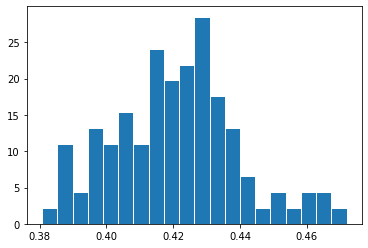

In [30]:
print(np.mean(taxas_acerto))
print(np.median(taxas_acerto))
plt.hist(taxas_acerto, density=True, edgecolor='white', bins=20)
plt.show()

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

<b>Análise do histograma:</b> a partir do histograma, obsserva-se que as taxas de acerto variam bastante dependendo dos dados de treinamento, tornando o comportamento do classificador relativamente imprevisível sob esse aspecto. No entanto, maior parte das iterações de treinamento atingem uma taxa de acerto próxima 

___
## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis
* Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)


___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**